In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [12]:
#Data Loading
# Data Loading
tickerSymbol = 'IBM'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start='2020-1-1', end='2024-3-1')
print('\nHeaD')
print(tickerDf.head())
print('\nDescribe')
print(tickerDf.describe())
print('\n\n shape')
print(tickerDf.shape)
print('Check for missing values')   
print(tickerDf.isnull().sum())




HeaD
                                 Open        High         Low       Close  \
Date                                                                        
2020-01-02 00:00:00-05:00  105.019604  105.735298  104.840687  105.346336   
2020-01-03 00:00:00-05:00  103.907196  104.910722  103.899417  104.506203   
2020-01-06 00:00:00-05:00  103.790482  104.428376  103.619337  104.319473   
2020-01-07 00:00:00-05:00  104.000525  104.988487  103.774929  104.389481   
2020-01-08 00:00:00-05:00  104.638413  105.688612  104.179436  105.260750   

                            Volume  Dividends  Stock Splits  
Date                                                         
2020-01-02 00:00:00-05:00  3293436        0.0           0.0  
2020-01-03 00:00:00-05:00  2482890        0.0           0.0  
2020-01-06 00:00:00-05:00  2537073        0.0           0.0  
2020-01-07 00:00:00-05:00  3232977        0.0           0.0  
2020-01-08 00:00:00-05:00  4545916        0.0           0.0  

Describe
          

In [13]:
#PreProcessing 
#null
# PreProcessing with Iterative Imputer for missing values
imputer = IterativeImputer(max_iter=10, random_state=0)
tickerDf_imputed = imputer.fit_transform(tickerDf)
tickerDf_final = pd.DataFrame(tickerDf_imputed, columns=tickerDf.columns, index=tickerDf.index)




In [14]:


# Identifying and Capping Outliers using IQR
Q1 = tickerDf_final.quantile(0.25)
Q3 = tickerDf_final.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
for col in tickerDf_final.columns:
    tickerDf_final[col] = tickerDf_final[col].clip(lower_bound[col], upper_bound[col])

# Display the first few rows and the descriptive stats after capping outliers
print("\nHead of the data after handling outliers:")
print(tickerDf_final.head())  # corrected variable name here
print("\nDescriptive stats after capping outliers:")
print(tickerDf_final.describe())  # corrected variable name here



Head of the data after handling outliers:
                                 Open        High         Low       Close  \
Date                                                                        
2020-01-02 00:00:00-05:00  105.019604  105.735298  104.840687  105.346336   
2020-01-03 00:00:00-05:00  103.907196  104.910722  103.899417  104.506203   
2020-01-06 00:00:00-05:00  103.790482  104.428376  103.619337  104.319473   
2020-01-07 00:00:00-05:00  104.000525  104.988487  103.774929  104.389481   
2020-01-08 00:00:00-05:00  104.638413  105.688612  104.179436  105.260750   

                              Volume  Dividends  Stock Splits  
Date                                                           
2020-01-02 00:00:00-05:00  3293436.0        0.0           0.0  
2020-01-03 00:00:00-05:00  2482890.0        0.0           0.0  
2020-01-06 00:00:00-05:00  2537073.0        0.0           0.0  
2020-01-07 00:00:00-05:00  3232977.0        0.0           0.0  
2020-01-08 00:00:00-05:00  454591

In [15]:
# Calculate 7-day and 30-day moving averages of the Close price
tickerDf['7_day_MA'] = tickerDf['Close'].rolling(window=7).mean()
tickerDf['30_day_MA'] = tickerDf['Close'].rolling(window=30).mean()

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    average_gain = pd.Series(gain).rolling(window=window).mean()
    average_loss = pd.Series(loss).rolling(window=window).mean()

    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI for the Close price
tickerDf['RSI'] = calculate_rsi(tickerDf['Close'])

# Display the head of the DataFrame to see the new features
print(tickerDf.head(20))


                                 Open        High         Low       Close  \
Date                                                                        
2020-01-02 00:00:00-05:00  105.019604  105.735298  104.840687  105.346336   
2020-01-03 00:00:00-05:00  103.907196  104.910722  103.899417  104.506203   
2020-01-06 00:00:00-05:00  103.790482  104.428376  103.619337  104.319473   
2020-01-07 00:00:00-05:00  104.000525  104.988487  103.774929  104.389481   
2020-01-08 00:00:00-05:00  104.638413  105.688612  104.179436  105.260750   
2020-01-09 00:00:00-05:00  105.595253  106.412076  105.260748  106.373177   
2020-01-10 00:00:00-05:00  106.575465  107.252259  106.038700  106.334305   
2020-01-13 00:00:00-05:00  105.393021  106.295417  105.074074  106.264290   
2020-01-14 00:00:00-05:00  106.015348  106.684370  105.447469  105.657501   
2020-01-15 00:00:00-05:00  105.797542  107.400063  105.571940  106.279861   
2020-01-16 00:00:00-05:00  106.824388  107.501182  106.583240  107.337822   

In [16]:
# Scaling
scaler = MinMaxScaler()
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']  # assuming these are the features you want to scale
tickerDf_final[features_to_scale] = scaler.fit_transform(tickerDf_final[features_to_scale])


In [17]:
# Resampling the data to monthly frequency
tickerDf_monthly = tickerDf_final.resample('M').mean()

# Splitting the dataset into train and test sets based on the monthly data
train_size = int(len(tickerDf_monthly) * 0.8)
train, test = tickerDf_monthly[:train_size], tickerDf_monthly[train_size:]

print("\nTrain dataset size:", len(train))
print("Test dataset size:", len(test))


Train dataset size: 40
Test dataset size: 10


/var/folders/j2/h4vx0kps61q_zfy2ms363w5w0000gn/T/ipykernel_93439/3847204290.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tickerDf_monthly = tickerDf_final.resample('M').mean()


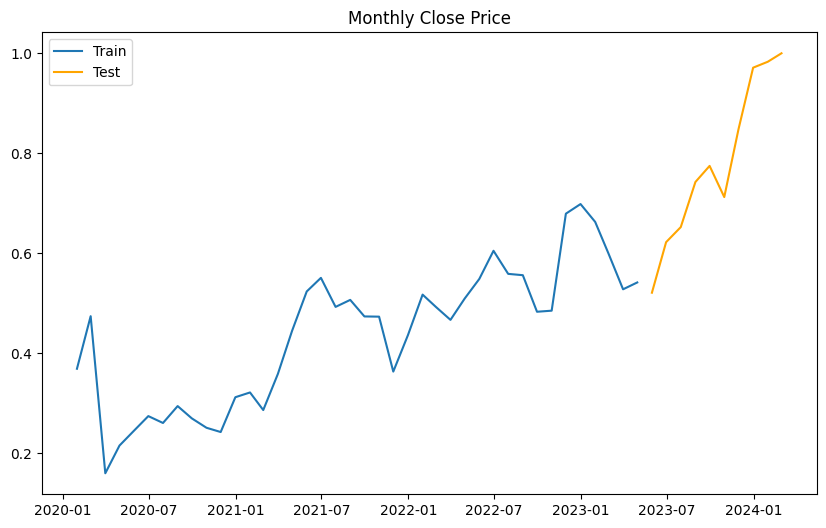

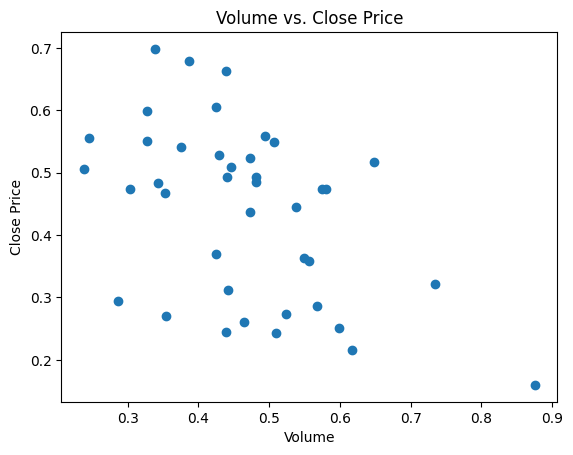

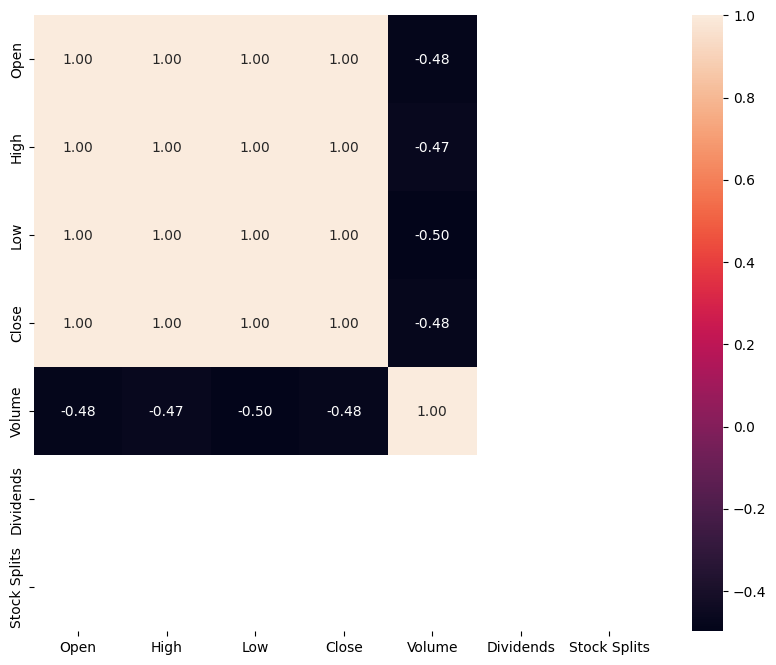

In [18]:
# Visualizing the Close Price trend
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test', color='orange')
plt.title('Monthly Close Price')
plt.legend()
plt.show()

# Visualizing Volume vs Close Price relationship
plt.scatter(train['Volume'], train['Close'])
plt.title('Volume vs. Close Price')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.show()

# Computing and Visualizing Correlation Matrix
corr_matrix = train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

1) you can get volatility, 
2) there isnt any obvious corellation  
3) you get correlation anD wich feature is imp for moDeling 

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# We will predict the 'Close' price using all other features in the dataset.
# First, prepare the data for training and testing:
X = train.drop('Close', axis=1)  # Features
y = train['Close']                # Target variable

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize models
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=0)

# Fit models on the training data
lr_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_lr = lr_model.predict(X_val)
y_pred_dt = dt_model.predict(X_val)

# Calculate MSE and R-squared for Linear Regression Model
mse_lr = mean_squared_error(y_val, y_pred_lr)
r2_lr = r2_score(y_val, y_pred_lr)

# Calculate MSE and R-squared for Decision Tree Model
mse_dt = mean_squared_error(y_val, y_pred_dt)
r2_dt = r2_score(y_val, y_pred_dt)



# Compare and choose the best model based on MSE and R-squared
# The model with the lowest MSE and the highest R-squared value is typically considered the best performer
from statsmodels.tsa.arima.model import ARIMA

# Since ARIMA is univariate, we only need the target variable 'Close'
y_train_arima = train['Close']

# Define and fit the ARIMA model (the order (p,d,q) needs to be chosen based on ACF and PACF plots or grid search)
arima_model = ARIMA(y_train_arima, order=(1, 1, 1))  # Example order, adjust based on your data
arima_result = arima_model.fit()

# Predict on the test set (Note: for ARIMA, you might predict in-sample first then forecast out-of-sample)
y_pred_arima = arima_result.forecast(steps=len(test))

# Calculate MSE and R-squared for ARIMA Model (You may need to adjust the indices if they don't align)
mse_arima = mean_squared_error(test['Close'], y_pred_arima)
r2_arima = r2_score(test['Close'], y_pred_arima)


# Print performance metrics for each model
print(f'Linear Regression - MSE: {mse_lr}, R-squared: {r2_lr}')
print(f'Decision Tree - MSE: {mse_dt}, R-squared: {r2_dt}')
print(f'ARIMA - MSE: {mse_arima}, R-squared: {r2_arima}')


Linear Regression - MSE: 7.942877886996479e-07, R-squared: 0.9999332951697026
Decision Tree - MSE: 5.9002417185978236e-05, R-squared: 0.9950449367577852
ARIMA - MSE: 0.07250536501345978, R-squared: -1.9586950954399098


/Users/mahsadorri/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mahsadorri/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MSE kheili paiin: Linear Regression kheili kam error dar pishbini dasht, yani ekhtelafat bein-e pishbini-ha va arzesh-haye asli (actual values) kheili kam bude.
R-squared nazdik be 1: In neshan mide ke model mitavane variance-e (pakhsh-e) data ro ba daghighate kheili bala explicate (tawzih) kone. Yek R-squared-e 0.999 yani model 99.993% az tafavotate data ro tawzih dade, ke neshan-dehende-ye yek fit-e kheili khub be data-ye amoozeshi ast.

In [20]:
# Hyperparameter Tuning for Decision Tree
from sklearn.model_selection import GridSearchCV

# Set up the parameters grid to search
param_grid = {'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Initialize the grid search
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=0),
                           param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Find the best model
best_tree = grid_search.best_estimator_

# Predict and evaluate using the best model
y_pred_best_tree = best_tree.predict(X_val)
mse_best_tree = mean_squared_error(y_val, y_pred_best_tree)
r2_best_tree = r2_score(y_val, y_pred_best_tree)

print(f'Best Decision Tree - MSE: {mse_best_tree}, R-squared: {r2_best_tree}')

Best Decision Tree - MSE: 5.9002417185978236e-05, R-squared: 0.9950449367577852


Given the exceptional performance of Linear Regression on this dataset, it's recommended to use this model for future prediction tasks. However, it's always beneficial to experiment with other models too, as changes in data or use case scenarios could lead to different models performing better. Understanding why a model performs well or poorly in a given scenario can also aid in comprehending the data and improving future models.






